In [1]:
import math
import random
from datetime import timedelta, datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import BaseCrossValidator

import yfinance as yf
import tensorflow as tf

from backtesting import Strategy, Backtest
from backtesting.lib import crossover
from skopt.plots import plot_objective

/opt/anaconda3/lib/python3.7/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Backtesting Strategies
Additional info: https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html

In [2]:
import inspect
import strats, get_data, backtest
from typing import Tuple

In [3]:
stock_obj = get_data.yFinData("SPY")
try:
    ydata = stock_obj.get_ohlcv()
except:
    print('Uable to download data.')

In [4]:
ydata.iloc[-int(float(10)*252):-int(float(1)*252)]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-03-02,107.151460,108.028346,106.823660,107.528442,200277400,0.0,0
2011-03-03,108.503653,109.503461,108.495462,109.380539,176480100,0.0,0
2011-03-04,109.298577,109.511659,107.848047,108.561020,277202300,0.0,0
2011-03-07,108.880691,109.126547,107.143324,107.708778,216790400,0.0,0
2011-03-08,107.880854,108.995394,107.413737,108.651199,174615000,0.0,0
...,...,...,...,...,...,...,...
2020-02-28,283.407423,292.428950,280.305350,290.828827,385764000,0.0,0
2020-03-02,292.743037,303.492308,289.061785,303.423584,238703600,0.0,0
2020-03-03,303.826122,308.086556,292.114835,294.735870,300139100,0.0,0


In [5]:
past10 = ydata.iloc[-int(float(10)*252):-int(float(3)*252)]
bt10 = Backtest(past10, strats.SmaCross, cash=10_000, commission=0.0)

stats, heatmap = bt10.optimize(
    fast=range(10, 100, 10),
    slow=[20, 30, 40],
    constraint=lambda p: p.fast < p.slow,
    maximize='Equity Final [$]',
    max_tries=100,
    random_state=0,
    return_heatmap=True)

In [ ]:
heatmap

In [ ]:
stats_skopt, heatmap, optimize_result = bt10.optimize(
    fast = [5, 100],
    slow = [10, 200],
    constraint=lambda p: p.fast < p.slow,
    maximize='Sharpe Ratio',
    method='skopt',
    max_tries=100,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

In [ ]:
_ = plot_objective(optimize_result, n_points=10)

In [ ]:
optimize_result.x[0]

In [ ]:
bt = Backtest(past10, strats.SmaCross, cash=10_000, commission=0.0)
stats = bt.run(fast = 93, slow = 142)
stats

In [ ]:
past1 = ydata.iloc[-int(float(3)*252):]
bt1 = Backtest(past1, strats.SmaCross, cash=10_000, commission=0.0)
stats = bt1.run(fast = 93, slow = 142)
stats

## CPCV

In [6]:
class CPCV(BaseCrossValidator):
    # TODO: add purge "holes" !!!
    def __init__(self, X, N, k):
        self.X = X
        self.N = N
        self.k = k

    def generate_eras(self):
        # assuming exact division, we will cut-off small piece of time series
        # in the very beginning
        return np.array(sum([
                    [i] * (len(self.X) // self.N) for i in range(self.N)
                    ], []
                   )
        )
        
    def split(self, X=None, y=None, groups=None):
        # removing first m items from time series
        eras = self.generate_eras()
        len_diff = abs(len(self.X) - len(eras))
        comb = list(combinations(range(self.N), self.N-self.k))
        all_splits = range(self.N)

        for combination in comb:
            train_indices, test_indices = [], []
            for c in combination:
                indices_train = list(np.where(eras == c)[0])
                train_indices.extend(indices_train)
            for t in list(set(all_splits) - set(combination)):
                indices_test = list(np.where(eras == t)[0])
                test_indices.extend(indices_test)
            yield(train_indices, test_indices)  
              
    def get_n_splits(self):
        comb = combinations(range(self.N), self.N-self.k)
        return len(list(comb))

In [9]:
N = 6
k = 2
comb = combinations(range(N), N-k)
for e, c in enumerate(list(comb)): 
    print(e+1, c)

1 (0, 1, 2, 3)
2 (0, 1, 2, 4)
3 (0, 1, 2, 5)
4 (0, 1, 3, 4)
5 (0, 1, 3, 5)
6 (0, 1, 4, 5)
7 (0, 2, 3, 4)
8 (0, 2, 3, 5)
9 (0, 2, 4, 5)
10 (0, 3, 4, 5)
11 (1, 2, 3, 4)
12 (1, 2, 3, 5)
13 (1, 2, 4, 5)
14 (1, 3, 4, 5)
15 (2, 3, 4, 5)


DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2011-10-04', '2011-10-05', '2011-10-06', '2011-10-07',
               '2011-10-10', '2011-10-11', '2011-10-12', '2011-10-13',
               '2011-10-14', '2011-10-17'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['2011-10-18', '2011-10-19', '2011-10-20', '2011-10-21',
               '2011-10-24', '2011-10-25', '2011-10-26', '2011-10-27',
               '2011-10-28', '2011-10-31',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


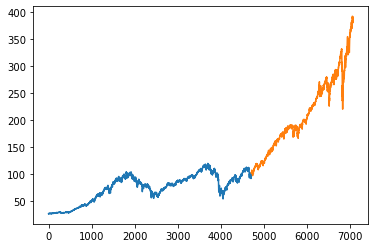

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['2007-02-14', '2007-02-15', '2007-02-16', '2007-02-20',
               '2007-02-21', '2007-02-22', '2007-02-23', '2007-02-26',
               '2007-02-27', '2007-02-28',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


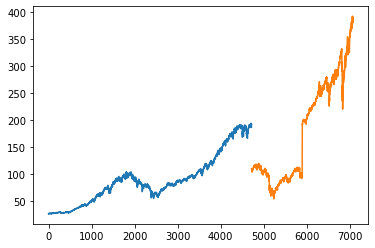

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['2007-02-14', '2007-02-15', '2007-02-16', '2007-02-20',
               '2007-02-21', '2007-02-22', '2007-02-23', '2007-02-26',
               '2007-02-27', '2007-02-28',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


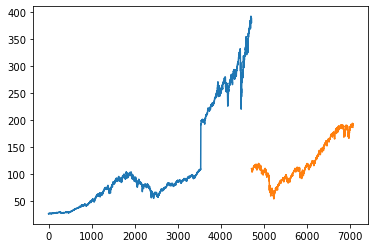

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['2002-06-10', '2002-06-11', '2002-06-12', '2002-06-13',
               '2002-06-14', '2002-06-17', '2002-06-18', '2002-06-19',
               '2002-06-20', '2002-06-21',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


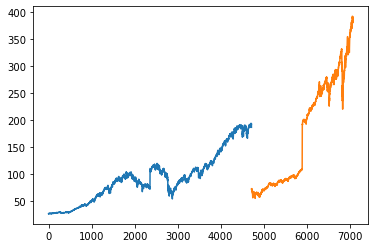

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['2002-06-10', '2002-06-11', '2002-06-12', '2002-06-13',
               '2002-06-14', '2002-06-17', '2002-06-18', '2002-06-19',
               '2002-06-20', '2002-06-21',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


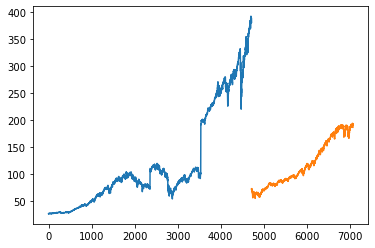

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['2002-06-10', '2002-06-11', '2002-06-12', '2002-06-13',
               '2002-06-14', '2002-06-17', '2002-06-18', '2002-06-19',
               '2002-06-20', '2002-06-21',
               ...
               '2011-10-04', '2011-10-05', '2011-10-06', '2011-10-07',
               '2011-10-10', '2011-10-11', '2011-10-12', '2011-10-13',
               '2011-10-14', '2011-10-17'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


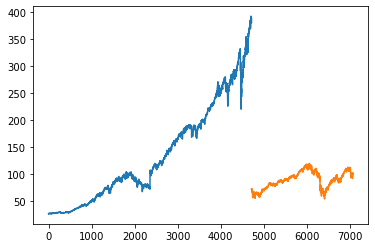

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


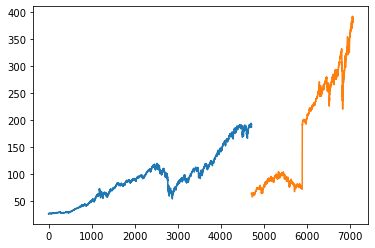

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


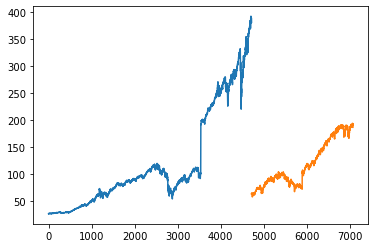

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2011-10-04', '2011-10-05', '2011-10-06', '2011-10-07',
               '2011-10-10', '2011-10-11', '2011-10-12', '2011-10-13',
               '2011-10-14', '2011-10-17'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


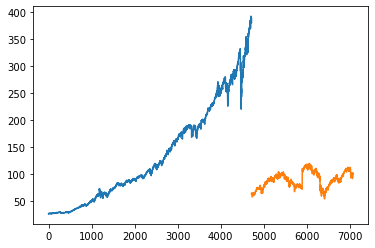

DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2007-01-31', '2007-02-01', '2007-02-02', '2007-02-05',
               '2007-02-06', '2007-02-07', '2007-02-08', '2007-02-09',
               '2007-02-12', '2007-02-13'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


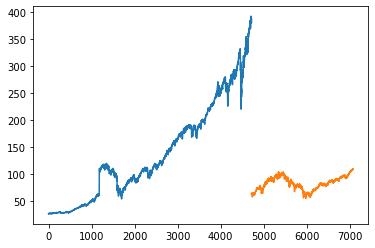

DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


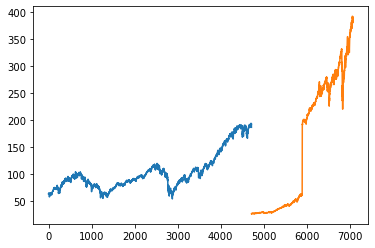

DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16',
               '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
               '2016-06-23', '2016-06-24'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


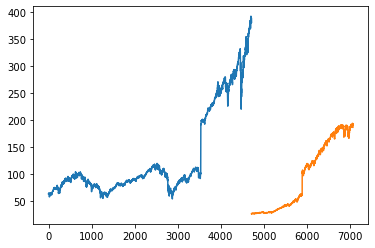

DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2011-10-04', '2011-10-05', '2011-10-06', '2011-10-07',
               '2011-10-10', '2011-10-11', '2011-10-12', '2011-10-13',
               '2011-10-14', '2011-10-17'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


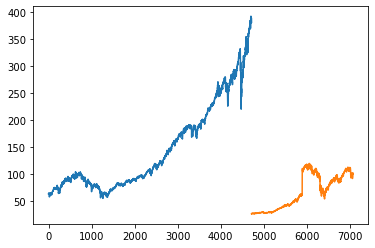

DatetimeIndex(['1997-09-29', '1997-09-30', '1997-10-01', '1997-10-02',
               '1997-10-03', '1997-10-06', '1997-10-07', '1997-10-08',
               '1997-10-09', '1997-10-10',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2007-01-31', '2007-02-01', '2007-02-02', '2007-02-05',
               '2007-02-06', '2007-02-07', '2007-02-08', '2007-02-09',
               '2007-02-12', '2007-02-13'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


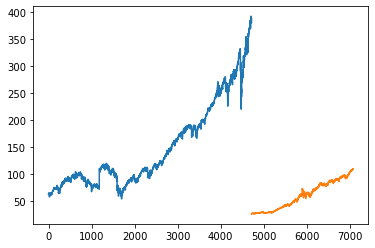

DatetimeIndex(['2002-06-10', '2002-06-11', '2002-06-12', '2002-06-13',
               '2002-06-14', '2002-06-17', '2002-06-18', '2002-06-19',
               '2002-06-20', '2002-06-21',
               ...
               '2021-02-18', '2021-02-19', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03'],
              dtype='datetime64[ns]', name='Date', length=4716, freq=None)
DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2002-05-24', '2002-05-28', '2002-05-29', '2002-05-30',
               '2002-05-31', '2002-06-03', '2002-06-04', '2002-06-05',
               '2002-06-06', '2002-06-07'],
              dtype='datetime64[ns]', name='Date', length=2358, freq=None)


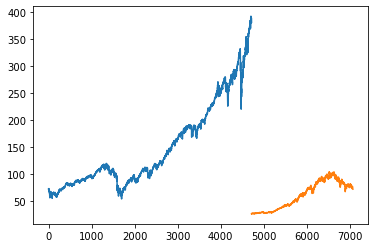

In [44]:
cpcv = CPCV(ydata, N, k)
for e, (train_ids, test_ids) in enumerate(cpcv.split()):
    dataset_train, dataset_test = ydata.iloc[train_ids], ydata.iloc[test_ids]
    print(dataset_train.index)
    print(dataset_test.index)
    plt.figure()
    plt.plot(range(len(dataset_train)), dataset_train.Close)
    plt.plot(range(len(dataset_train), len(dataset_train)+len(dataset_test)), dataset_test.Close)
    plt.show()

In [27]:
cpcv = CPCV(ydata, N, k)
train_temp = []
test_temp = []
NSAMPLES = 5
for e, (train_ids, test_ids) in enumerate(cpcv.split()):
    dataset_train, dataset_test = ydata.iloc[train_ids], ydata.iloc[test_ids]
    train, test = [], []
    for i in range(NSAMPLES):
        bt = Backtest(dataset_train, strats.SmaCross, cash=10_000, commission=0.0)
        stats_skopt, heatmap, optimize_result = bt.optimize(
            fast = [5, 50],
            slow = [10, 60],
            constraint=lambda p: p.fast < p.slow,
            maximize='Sharpe Ratio',
            method='skopt',
            max_tries=30,
            return_heatmap=True,
            return_optimization=True)
        stats = bt.run(fast = optimize_result.x[0], slow = optimize_result.x[1])
        btopt = Backtest(dataset_test, strats.SmaCross, cash=10_000, commission=0.0)
        optstats = btopt.run(fast = optimize_result.x[0], slow = optimize_result.x[1])
        train.append(stats)
        test.append(optstats)
    train_temp.append(train)
    test_temp.append(test)

train_stats = [pd.concat(train, axis=1) for train in train_temp]
test_stats = [pd.concat(test, axis=1) for test in test_temp]

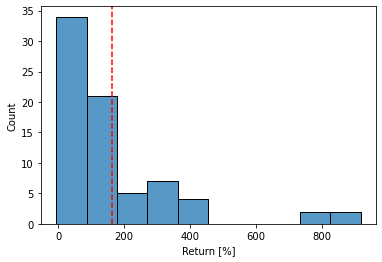

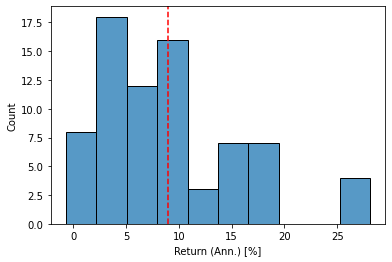

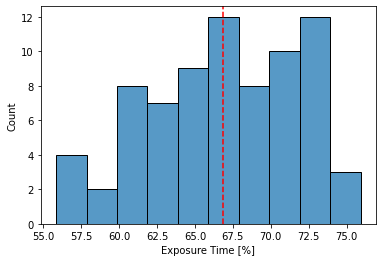

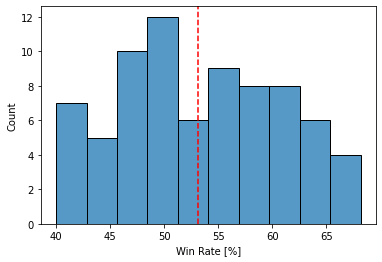

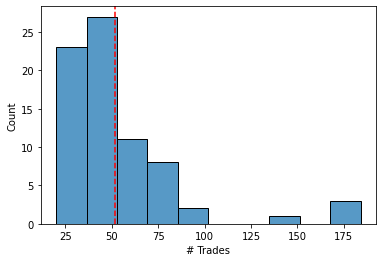

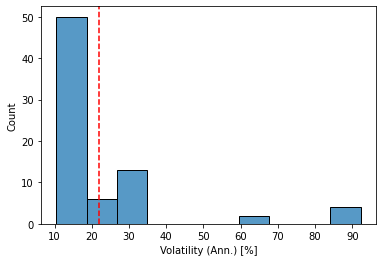

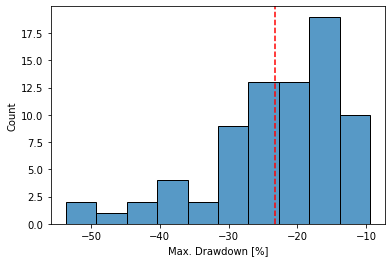

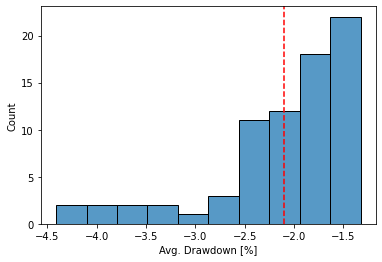

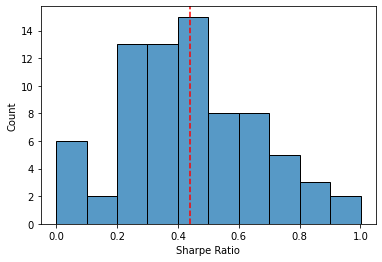

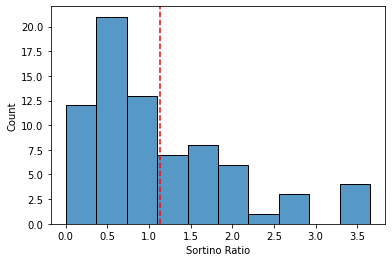

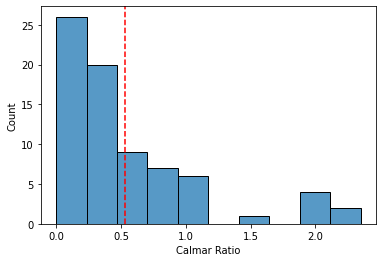

In [40]:
display = ['Return [%]', 'Return (Ann.) [%]', 'Exposure Time [%]', 'Win Rate [%]',
           '# Trades', 'Volatility (Ann.) [%]', 'Max. Drawdown [%]', 'Avg. Drawdown [%]',
           'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio'] 
for d in display:
    data = []
    for train, test in zip(train_stats, test_stats):
        train_data = train.loc[d,:].to_numpy()
        test_data = test.loc[d,:].to_numpy()
        data = np.concatenate((data, test_data), axis=None)
    plt.figure()
    ax = sns.histplot(data, bins=10)
    ax.set(xlabel=d, ylabel='Count')
    plt.axvline(data.mean(), ls = '--', color = 'red')
    plt.show()

### Some visualizations

In [ ]:
equity_trades['MacdSignal'][1]

In [ ]:
sma_trades['PnL'].hist(bins=30)
sma_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
macd_trades = equity_trades['MacdSignal'][1]
macd_trades['PnL'].hist(bins=30)
macd_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
rsi_trades = equity_trades['RsiSignal'][1]
rsi_trades['PnL'].hist(bins=30)
rsi_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
stoch_trades = equity_trades['StochOsci'][1]
stoch_trades['PnL'].hist(bins=30)
stoch_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

In [ ]:
stochrsi_trades = equity_trades['StochRsi'][1]
stochrsi_trades['PnL'].hist(bins=30)
stochrsi_trades.loc[:, ['PnL', "EntryTime"]].set_index('EntryTime').plot()

## Geometric Brownian Motion

In [ ]:
def train_models_to_reconstruct_ohlcv_from_close(data):
    # important note: trained on log data, need to exp later
    data2train = np.log(data[['High', 'Low', 'Open', 'Close', 'Volume']])
    X_prices, Y_prices = data2train['Close'], data2train[['High', 'Low', 'Open']]
    X_volume, Y_volume = data2train[['High', 'Low', 'Open', 'Close']], data2train['Volume']
    
    model_prices = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(3)
        ])
    model_prices.compile('adam', 'mae')
    model_prices.fit(X_prices, Y_prices, epochs=50, verbose=False)
    
    model_volume = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
        ])
    model_volume.compile('adam', 'mae')
    model_volume.fit(X_volume, Y_volume, epochs=50, verbose=False)
    return model_prices, model_volume

In [ ]:
model_prices, model_volume = train_models_to_reconstruct_ohlcv_from_close(ydata)

In [ ]:
def convert_to_returns(log_returns):
    """
    This method exponentiates a sequence of log returns to get daily returns.
    """
    return np.exp(log_returns)


def convert_to_prices(log_returns, s0 = 1e-3):
    """
    This method converts a sequence of log returns into normal returns (exponentiation) and then computes a price
    sequence given a starting price, param.all_s0.
    """
    returns = convert_to_returns(log_returns)
    price_sequence = [s0]
    for i in range(1, len(returns)):
        price_sequence.append(price_sequence[i - 1] * returns[i - 1])
    return np.array(price_sequence)

In [ ]:
def brownian_motion_log_returns(delta, sigma, N):
    """
    This method returns a Wiener process. The Wiener process is also called Brownian motion. For more information
    about the Wiener process check out the Wikipedia page: http://en.wikipedia.org/wiki/Wiener_process
    """
    sqrt_delta_sigma = math.sqrt(delta) * sigma
    return np.random.normal(loc=0, scale=sqrt_delta_sigma, size=N)

In [ ]:
def geometric_brownian_motion_log_returns(delta, mu, sigma, N):
    """
    This method constructs a sequence of log returns which, when exponentiated, produce a random Geometric Brownian
    Motion (GBM). GBM is the stochastic process underlying the Black Scholes options pricing formula.
    """
    wiener_process = np.array(brownian_motion_log_returns(delta, sigma, N))
    sigma_pow_mu_delta = (mu - 0.5 * math.pow(sigma, 2.0)) * delta
    return wiener_process + sigma_pow_mu_delta

In [ ]:
def jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N):
    """
    This method produces a sequence of Jump Sizes which represent a jump diffusion process. These jumps are combined
    with a geometric brownian motion (log returns) to produce the Merton model.
    """
    s_n = time = 0
    small_lamda = -(1.0 / lamda)
    jump_sizes = []
    for k in range(0, N):
        jump_sizes.append(0.0)
    while s_n < N:
        s_n += small_lamda * math.log(np.random.uniform(0, 1))
        for j in range(0, N):
            if time * delta <= s_n * delta <= (j + 1) * delta:
                # print("was true")
                jump_sizes[j] += random.normalvariate(jumps_mu, jumps_sigma)
                break
        time += 1
    return jump_sizes


def geometric_brownian_motion_jump_diffusion_log_returns(delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N):
    """
    This method constructs combines a geometric brownian motion process (log returns) with a jump diffusion process
    (log returns) to produce a sequence of gbm jump returns.
    """
    jump_diffusion = jump_diffusion_process(delta, lamda, jumps_mu, jumps_sigma, N)
    geometric_brownian_motion = geometric_brownian_motion_log_returns(delta, mu, sigma, N)
    return np.add(jump_diffusion, geometric_brownian_motion)

In [ ]:
ydata.Close.plot()

In [ ]:
# x = brownian_motion_log_returns(1, 0.000001, 1000)
# x = geometric_brownian_motion_log_returns(1, 0, 0.0312, 1000)

# delta, mu, sigma, lamda, jumps_mu, jumps_sigma, N
def simulate(data):
    mm, sstd = data.Close.pct_change().mean(), data.Close.pct_change().std()
    x = geometric_brownian_motion_jump_diffusion_log_returns(1, mm, sstd, 0.1, -0.01, 0.001, 1000)
    prices_simulation = convert_to_prices(x, 100)
    hlo_simulated = model_prices.predict(np.log(prices_simulation))
    hloc_simulated = np.concatenate((np.exp(hlo_simulated), np.expand_dims(prices_simulation, -1)), axis=1)
    volume_simulated = np.exp(model_volume.predict(np.log(hloc_simulated)))
    dataset_simulated = pd.DataFrame({
        'High': hloc_simulated[:, 0],
        'Open': hloc_simulated[:, 1],
        'Low': hloc_simulated[:, 2],
        'Close': hloc_simulated[:, 3],
        'Volume': volume_simulated.flatten()
    },
        index = [datetime.today() + timedelta(days=x) for x in range(len(hloc_simulated))])
    return dataset_simulated

In [ ]:
dataset_simulated = simulate(ydata)
dataset_simulated[['High', 'Low', 'Open', 'Close']].plot()